In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
    Dropout,
    Input, 
    Concatenate,
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D,
)
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input
from tensorflow import Tensor

# Image Read and Resize Function

In [ ]:
def load_raw_data():

    # covid_path = "../data/curated_data/curated_data/2COVID"
    # non_covid_path = "../data/curated_data/curated_data/1NonCOVID"
    # cap_path = "../data/curated_data/curated_data/3CAP"
    covid_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/2COVID"
    non_covid_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/1NonCOVID"
    cap_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/3CAP"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))
    cap_images = list(Path(cap_path).glob("*.png"))
    return covid_images, non_covid_images, cap_images

In [ ]:
covid_images, non_covid_images, cap_images = load_raw_data()

print(len(covid_images))
print(len(non_covid_images))
print(len(cap_images))

7593
6893
2618


In [ ]:
data_dir="/content/drive/MyDrive/COVID-19/data/curated_data/curated_data"
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17104 files belonging to 3 classes.
Using 13684 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17104 files belonging to 3 classes.
Using 3420 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['1NonCOVID', '2COVID', '3CAP']


In [ ]:
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

1NonCOVID   0
2COVID   1
3CAP   2


In [ ]:
#Defining model
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# # Compile the model
# # resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Save the model
# model_path = '../models/resnet50_model'
# resnet_model.save(model_path)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('resnet50_model')


In [ ]:
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
epochs=20
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
428/428 [==============================] - 2636s 6s/step - loss: 0.7200 - accuracy: 0.7026 - val_loss: 0.3404 - val_accuracy: 0.8675
Epoch 2/20
428/428 [==============================] - 2452s 6s/step - loss: 0.4207 - accuracy: 0.8403 - val_loss: 0.2376 - val_accuracy: 0.9099
Epoch 3/20
428/428 [==============================] - 2468s 6s/step - loss: 0.3344 - accuracy: 0.8754 - val_loss: 0.2034 - val_accuracy: 0.9211
Epoch 4/20
428/428 [==============================] - 2641s 6s/step - loss: 0.2942 - accuracy: 0.8907 - val_loss: 0.1916 - val_accuracy: 0.9246
Epoch 5/20
317/428 [=====================>........] - ETA: 8:31 - loss: 0.2690 - accuracy: 0.9008

KeyboardInterrupt: ignored

In [ ]:
resnet_model.save('/content/drive/MyDrive/COVID-19/models/model_resnet50.h5')

# Accuracy Curve

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

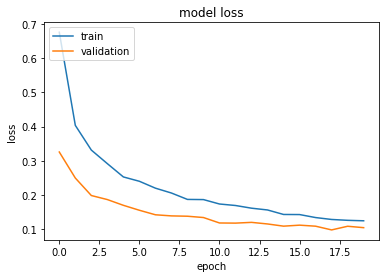

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#evaluate model
resnet_model.evaluate(val_ds)

107/107 [==============================] - 19s 167ms/step - loss: 0.1036 - accuracy: 0.9640


[0.10359631478786469, 0.9640350937843323]

[[1381   11    2]
 [ 109 1401    0]
 [   1    0  515]]
              precision    recall  f1-score   support

   1NonCOVID       0.93      0.99      0.96      1394
      2COVID       0.99      0.93      0.96      1510
        3CAP       1.00      1.00      1.00       516

    accuracy                           0.96      3420
   macro avg       0.97      0.97      0.97      3420
weighted avg       0.97      0.96      0.96      3420



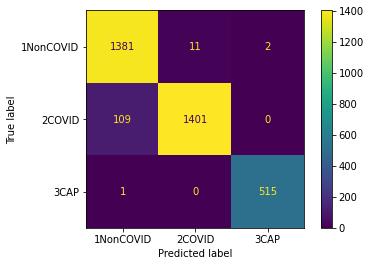

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
    predictions = np.concatenate([predictions, np.argmax(resnet_model.predict(x), axis=1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    
cf_matrix_test = confusion_matrix(labels, predictions)
print(cf_matrix_test)  
print(classification_report(labels, predictions, target_names=class_names))
cmd = ConfusionMatrixDisplay(cf_matrix_test, display_labels=class_names)
cmd.plot()